In [2]:
#Donwload Data
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
#torchvision.model :  contains definitions of models for addressing different tasks
#torchvision.datasets : can all be passed to a torch.utils.data.DataLoader which can load multiple samples parallelly using torch.multiprocessing workers.
#torchvision.transform : image transformation, can be chained together using Compose
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Check CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available. Training on CPU...")
else:
    print("CUDA is available! Training on GPU...")

CUDA is not available. Training on CPU...


In [4]:
#Load and transform out Data

#Define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
#flower_photos/train/
test_dir = os.path.join(data_dir, 'test/')
#flower_photos/test/
#os.path.join : Join one or more path components intelligently


#Claees are folders in each directory with these names
classes = ['daisy', 'dadelion', 'roses', 'sunflowers', 'tulips']

In [5]:
#Transforming the Data

#Load and transform data using ImageFolder
#VGG=16 takes 224x224 images as input, therefore, we need to resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform = data_transform)
test_data = datasets.ImageFolder(test_dir, transform = data_transform)
                                    
                                    

print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [6]:
#DataLoader and Data Visualization
batch_size = 20
num_workers = 0

#prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers, shuffle = True)


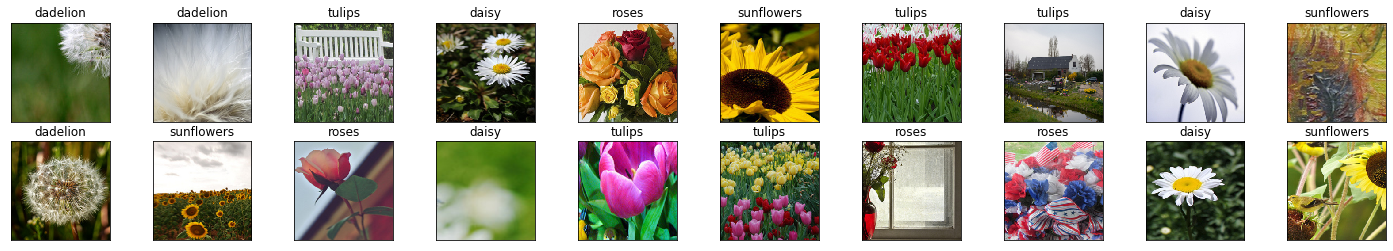

In [7]:
#Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
# Define the Model
#1. in a pre-trained VGG16 model
#2. "Freeze" all the parameters, so that the network act as a fixed feature extractor
#3. Remove the last layer
#4. Replace the last layer with a linear classifier of our own

In [9]:
#Load pre-trained model from pytorch
vgg16 = models.vgg16(pretrained = True)

#print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


In [11]:
#Freeze training of all 'features' layers
for pram in vgg16.features.parameters():
    pram.requires_grad = False  ##Frreze all layers ###

In [12]:
#Final Classifier Layer

import torch.nn as nn
# torch.nn : to build layers
#  configure different trainable layers including convolution and affine layers 
#  with nn.Conv2d and nn.Linear respectively

n_inputs = vgg16.classifier[6].in_features

#add last linear layer (n_inputs -> five flower classes (five different output class))
#New layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()
    
#Check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


In [13]:
#specify Loss function and optimizer
import torch.optim as optim

#Specify loss function 
criterion = nn.CrossEntropyLoss()

#Specify optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr = 0.001)

In [14]:
#Training 

#Number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs +1):
    
    #Keep track of training and validation loss
    train_loss = 0.0
    
    #### Trin Model ####
    #Model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        #Move tensor to GPU if cuda is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # 1. Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # 2. Forward pass : compute predicted outputs by passing inputs to the model
        outputs = vgg16(data)
        # 3. Calculate the batch loss
        loss = criterion(outputs, target)
        # 4. backward pss : compute gradient of the loss with respect to model parameters
        loss.backward()
        # 5. perform a single optimization step(Parameter Update)
        optimizer.step()
        # 6. Update training loss
        train_loss += loss.item()
        
        if batch_i %20 == 19:
            print("Epoch %d, Batch %d loss: %.16f" %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0
        

Epoch 1, Batch 20 loss: 1.5414559006690980
Epoch 1, Batch 40 loss: 1.3830502629280090
Epoch 1, Batch 60 loss: 1.2514323800802232
Epoch 1, Batch 80 loss: 1.0872129082679749
Epoch 1, Batch 100 loss: 1.0509996235370636
Epoch 1, Batch 120 loss: 0.9922759622335434
Epoch 1, Batch 140 loss: 0.9972145766019821
Epoch 2, Batch 20 loss: 0.8911495774984359
Epoch 2, Batch 40 loss: 0.8282698839902878
Epoch 2, Batch 60 loss: 0.8625609576702118
Epoch 2, Batch 80 loss: 0.8510550439357758
Epoch 2, Batch 100 loss: 0.7895212620496750
Epoch 2, Batch 120 loss: 0.7225584805011749
Epoch 2, Batch 140 loss: 0.7696191877126694


In [27]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    #if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.722924

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dadelion: 90% (120/132)
Test Accuracy of roses: 59% (54/91)
Test Accuracy of sunflowers: 70% (71/101)
Test Accuracy of tulips: 75% (94/124)

Test Accuracy (Overall): 75% (408/540)


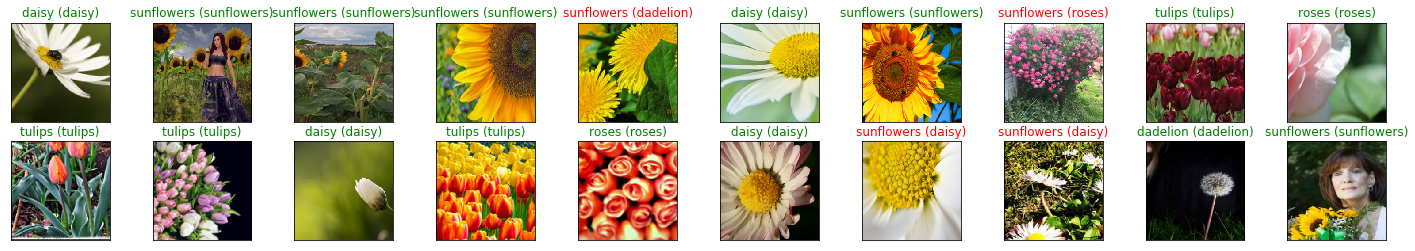

In [29]:
# VisualiE Sample Test Results

# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()
    
# 1. Get sample outputs
outputs = vgg16(images)
# 2. Convert output probabilities to prediced class
_,preds_tensor = torch.max(outputs, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


# 3. Plot the imges in the batch, along with predicted and true labels
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))